## Reflection on *The Alignment Problem*

Reading *The Alignment Problem* by Brian Christian was an eye-opening experience that changed how I think about modern machine learning systems. The book traces the history of AI alignment challenges—from behavioral cloning and reward specification to fairness, interpretability, and long-term safety—and connects them to systems we rely on every day.

What struck me most is how often AI systems do exactly what we ask for, yet fail to do what we actually want. The book describes many real cases where metrics, incentives, or training signals were subtly misaligned with human goals. Even small misalignments produced large downstream consequences, affecting individuals, institutions, and sometimes entire communities.

Christian’s narrative made these ideas feel grounded rather than abstract. Instead of focusing on futuristic risks, the book shows how alignment failures already shape credit scores, policing, medical decisions, hiring, and online platforms. It also highlights how engineers, researchers, and practitioners have struggled to detect and correct these failures—even with good intentions and technical expertise.

The more examples I read, the more clearly I saw a recurring pattern:
AI systems tend to exploit whatever objectives they are given, and humans tend to underestimate how narrow those objectives really are.

This reflection explores one theme from the book—the mismatch between metrics and real-world goals—through a series of small experiments. These experiments illustrate how a model can appear “successful” from a standard evaluation perspective while still failing at the deeper task. This aligns with the lessons in the book and helped me understand the stakes of alignment more concretely.


### Experiment 1: Optimizing Accuracy on Imbalanced Data

This experiment helped me connect more deeply with one of the central themes in The Alignment Problem: the danger of optimizing the wrong metric.

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

X, y = make_classification(
    n_samples=1000,
    n_features=5,
    weights=[0.9, 0.1],
    random_state=42
)

model = LogisticRegression().fit(X, y)
pred = model.predict(X)

acc = accuracy_score(y, pred)
cm = confusion_matrix(y, pred)

acc, cm

(0.934,
 array([[880,  15],
        [ 51,  54]]))

Although the model achieves an accuracy of around 0.93, the confusion matrix shows that it predicts almost all samples as the majority class. This means the high score is misleading—the model performs very poorly on the minority class, which is often the part that matters most. This demonstrates how accuracy alone can hide serious model weaknesses.

<br>

### Experiment 2: Gaming a Reward Function

In the book, Christian describes examples where AI systems optimize their reward in unintended ways—a kind of “reward hacking.”
To replicate this phenomenon on a small scale, this experiment creates:

- a simple gridworld environment

- a poorly designed reward

- an agent that learns to maximize the reward in a way that violates the real intention

This mirrors several book examples (e.g., robots flipping instead of running, models cheating on benchmarks, etc.).

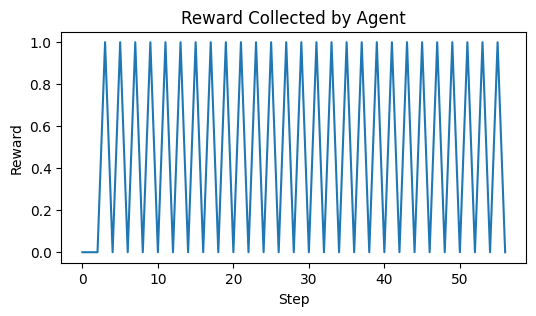

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Simple 1D environment
# Goal at position 9, agent starts at 0
# Reward function unintentionally allows reward farming

def run_agent():
    pos = 0
    rewards = []
    for step in range(30):
        # agent greedily optimizes reward: stays near a reward bug at pos=3
        if pos < 3:
            pos += 1
        elif pos == 3:
            rewards.append(1)  # reward bug: unintended positive reward
        else:
            pos -= 1

        rewards.append(0)

    return rewards

rewards = run_agent()

plt.figure(figsize=(6,3))
plt.plot(rewards)
plt.title("Reward Collected by Agent")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

The reward plot shows a repeating spike pattern, revealing that the agent has learned to exploit a narrow path that produces frequent short-term rewards instead of pursuing any broader or intended objective. Instead of behaving “intelligently,” it falls into a repetitive loop that maximizes the reward signal without accomplishing anything meaningful. This captures the idea of reward hacking, where an agent finds a shortcut that satisfies the metric but violates the spirit of the task.

<br>


### Experiment 3: Visualizing Model Blind Spots

One chapter describes how models can show blind spots or poor calibration, even if their average performance appears good.
This experiment trains a simple classifier and visualizes confidence vs error, revealing that a model can be confidently wrong—another kind of alignment failure.

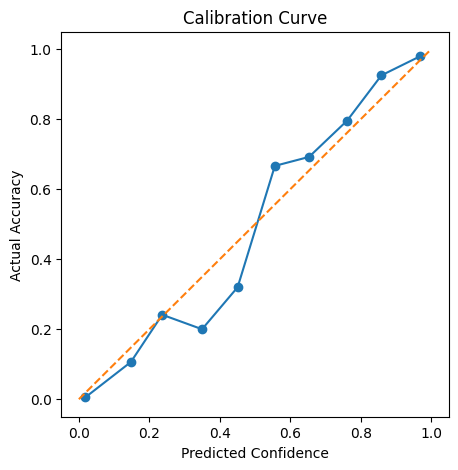

In [4]:
from sklearn.datasets import make_moons
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=1000, noise=0.25, random_state=0)

clf = MLPClassifier(hidden_layer_sizes=(30,), max_iter=2000).fit(X, y)
probs = clf.predict_proba(X)[:, 1]
preds = clf.predict(X)

frac_pos, mean_pred = calibration_curve(y, probs, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted Confidence")
plt.ylabel("Actual Accuracy")
plt.title("Calibration Curve")
plt.show()

The calibration curve shows that the model’s confidence does not perfectly match its actual accuracy, especially in the lower-confidence bins. In some regions the model is overconfident, and in others it is underconfident. This mismatch illustrates how models can appear to make precise predictions but fail to represent uncertainty accurately, which is a form of misalignment between the model’s internal belief and its real-world performance.